## Documentation and creation of tables

First, load reference data from Dressel & Farid (2018) and calculate performance metrics F1-score, precision, recall for each group. 

In [44]:
import pandas as pd

# Original reference values from Table 2
data = {
    "Metric": [
        "Accuracy (overall)",
        "Accuracy (black)",
        "Accuracy (white)",
        "False positive (black)",
        "False positive (white)",
        "False negative (black)",
        "False negative (white)"
    ],
    "LR_7": [
        "66.6%",
        "66.7%",
        "66.0%",
        "42.9%",
        "25.3%",
        "24.2%",
        "47.3%"
    ]
}

df_results_reference = pd.DataFrame(data)

# === Extract float values from strings ===
def extract_percentage(s):
    return float(s.split('%')[0]) / 100

# Extract FP and FN rates
def extract_rates(df, model):
    fp_black = extract_percentage(df.loc[3, model])
    fp_white = extract_percentage(df.loc[4, model])
    fn_black = extract_percentage(df.loc[5, model])
    fn_white = extract_percentage(df.loc[6, model])
    return fp_black, fp_white, fn_black, fn_white

# Compute precision, recall, F1
def compute_metrics(fp, fn):
    recall = 1 - fn
    precision = recall / (recall + fp) if (recall + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return round(precision * 100, 1), round(recall * 100, 1), round(f1 * 100, 1)

# For LR_7
lr_fp_black, lr_fp_white, lr_fn_black, lr_fn_white = extract_rates(df_results_reference, 'LR_7')
lr_prec_b, lr_rec_b, lr_f1_b = compute_metrics(lr_fp_black, lr_fn_black)
lr_prec_w, lr_rec_w, lr_f1_w = compute_metrics(lr_fp_white, lr_fn_white)

# === Append results ===
df_extra = pd.DataFrame({
    "Metric": [
        "Precision (black)",
        "Recall (black)",
        "F1-score (black)",
        "Precision (white)",
        "Recall (white)",
        "F1-score (white)"
    ],
    "LR_7": [
        f"{lr_prec_b}%",
        f"{lr_rec_b}%",
        f"{lr_f1_b}%",
        f"{lr_prec_w}%",
        f"{lr_rec_w}%",
        f"{lr_f1_w}%"
    ]
})

# Merge and export
df_results_reference = pd.concat([df_results_reference, df_extra], ignore_index=True)

# Save CSV
output_path = "../reports/05_documentation/reference_results_dressel_farid_2018.csv"
df_results_reference.to_csv(output_path, index=False)

df_results_reference



,Metric,LR_7
0,Accuracy (overall),66.6%
1,Accuracy (black),66.7%
2,Accuracy (white),66.0%
3,False positive (black),42.9%
4,False positive (white),25.3%
5,False negative (black),24.2%
6,False negative (white),47.3%
7,Precision (black),63.9%
8,Recall (black),75.8%
9,F1-score (black),69.3%


Calculate and plot confusion matrices for final finetuned and debiased own models: 


Confusion Matrix for Logistic Regression (White):
          Pred 0  Pred 1
Actual 0     272      93
Actual 1      30     117


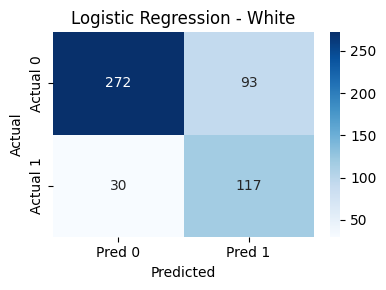


Confusion Matrix for Logistic Regression (Black):
          Pred 0  Pred 1
Actual 0     328     149
Actual 1      59     249


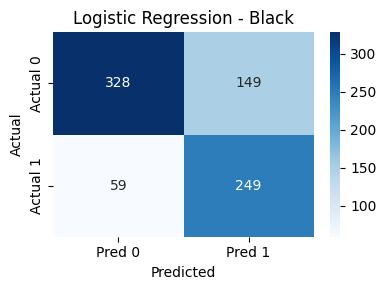


Confusion Matrix for AdaBoost (White):
          Pred 0  Pred 1
Actual 0     312      53
Actual 1      47     100


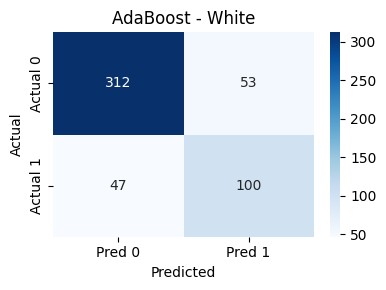


Confusion Matrix for AdaBoost (Black):
          Pred 0  Pred 1
Actual 0     390      87
Actual 1     100     208


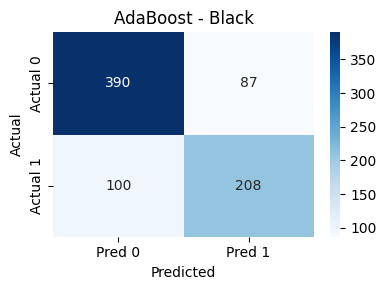


Confusion Matrix for Neural Network (White):
          Pred 0  Pred 1
Actual 0     273      92
Actual 1      29     118


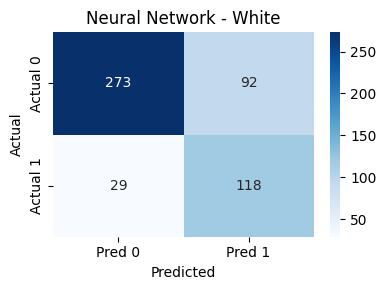


Confusion Matrix for Neural Network (Black):
          Pred 0  Pred 1
Actual 0     347     130
Actual 1      59     249


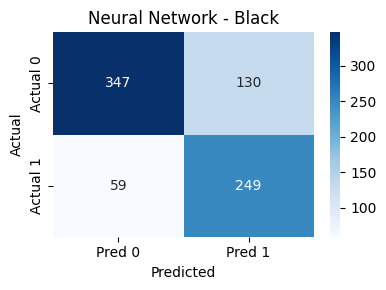


Confusion Matrix for Logistic Regression Debiased Final (White):
          Pred 0  Pred 1
Actual 0     272      93
Actual 1      30     117


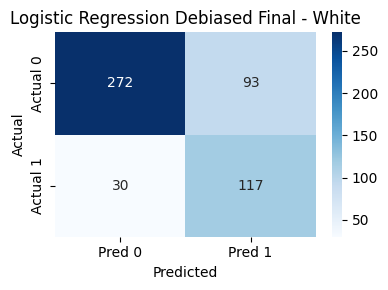


Confusion Matrix for Logistic Regression Debiased Final (Black):
          Pred 0  Pred 1
Actual 0     328     149
Actual 1      59     249


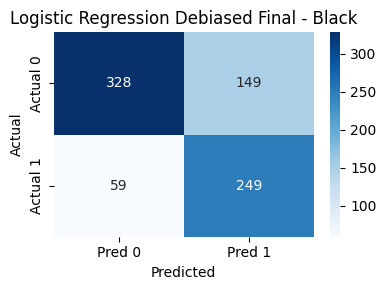


Confusion Matrix for Neural Network Debiased Final (White):
          Pred 0  Pred 1
Actual 0     273      92
Actual 1      29     118


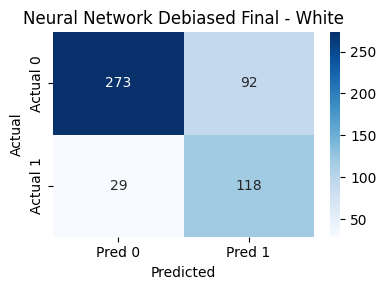


Confusion Matrix for Neural Network Debiased Final (Black):
          Pred 0  Pred 1
Actual 0     347     130
Actual 1      59     249


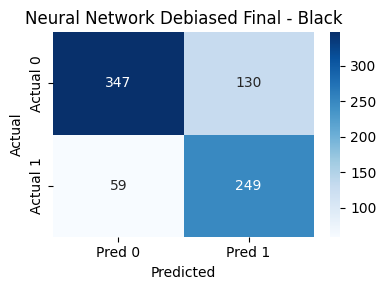

In [50]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# === Step 1: Load data and pipeline ===
df = pd.read_csv("../data/cox-violent-preprocessed.csv")
pipeline = joblib.load("../models/pipeline_preprocessing.pkl")

X_raw = df.drop("is_recid", axis=1).copy()
y = df["is_recid"].copy()
X_transformed = pipeline.transform(X_raw)

# Select modeling features
selected_features = [
    "age", "sex", "juv_misd_count", "juv_fel_count",
    "priors_count", "c_charge_degree", "c_charge_desc"
]
feature_indices = [X_raw.columns.get_loc(f) for f in selected_features]
X_selected = X_transformed[:, feature_indices]

# Train/Val/Test Split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_selected, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.176, stratify=y_trainval, random_state=42
)

# === Step 2: Extract sensitive attribute ===
X_test_df = X_raw.iloc[y_test.index].copy()
race_test = X_test_df["race"].values
race_test_renamed = np.where(race_test == "Caucasian", "White",
                     np.where(race_test == "African-American", "Black", race_test))
sensitive_groups = ["White", "Black"]

# === Step 3: Load all models ===
models = {
    "Logistic Regression": joblib.load("../models/tuned/logistic_regression_finetuned.pkl"),
    "AdaBoost": joblib.load("../models/tuned/adaboost_finetuned.pkl"),
    "Neural Network": joblib.load("../models/tuned/neural_network_finetuned.pkl"),
}

# Load debiased models (may include thresholds)
debiased_path = "../models/debiased_final"
for filename in os.listdir(debiased_path):
    if filename.endswith(".pkl"):
        model_name = filename.replace("_", " ").replace(".pkl", "").title()
        path = os.path.join(debiased_path, filename)
        loaded = joblib.load(path)
        if isinstance(loaded, dict) and "model" in loaded and "thresholds" in loaded:
            models[model_name] = loaded
        else:
            models[model_name] = loaded

# === Step 4: Helper to apply threshold-based predictions ===
def predict_with_thresholds(model_dict, X, group_labels, group_values):
    model = model_dict["model"]
    thresholds = model_dict["thresholds"]
    proba = model.predict_proba(X)[:, 1]
    preds = np.zeros_like(proba, dtype=int)

    for group in group_values:
        mask = (group_labels == group)
        thresh = thresholds.get(group, 0.5)
        preds[mask] = (proba[mask] >= thresh).astype(int)

    return preds

# === Step 5: Compute and plot confusion matrices ===
def compute_confusion_by_group(model_name, model_obj, X, y_true, group_labels, group_values):
    if isinstance(model_obj, dict) and "model" in model_obj and "thresholds" in model_obj:
        y_pred = predict_with_thresholds(model_obj, X, group_labels, group_values)
    else:
        y_pred = model_obj.predict(X)

    results = {}

    # Ensure output directory exists
    output_dir = "../reports/05_documentation"
    os.makedirs(output_dir, exist_ok=True)

    for group in group_values:
        mask = (group_labels == group)
        cm = confusion_matrix(y_true[mask], y_pred[mask], labels=[0, 1])
        results[group] = cm

        print(f"\nConfusion Matrix for {model_name} ({group}):")
        print(pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"]))

        # Plot
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Pred 0", "Pred 1"],
                    yticklabels=["Actual 0", "Actual 1"])
        plt.title(f"{model_name} - {group}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        
        # Sanitize filename and save
        safe_model = model_name.lower().replace(" ", "_")
        safe_group = group.lower()
        filename = f"{output_dir}/confusion_matrix_{safe_model}_{safe_group}.png"
        plt.savefig(filename)
        plt.show() 

    return results

# === Step 6: Run for all models ===
confusion_matrices_by_model = {}

for model_name, model_obj in models.items():
    try:
        cm_results = compute_confusion_by_group(model_name, model_obj, X_test, y_test,
                                                race_test_renamed, sensitive_groups)
        confusion_matrices_by_model[model_name] = cm_results
    except Exception as e:
        print(f"[ERROR] {model_name}: {e}")


Calculate accuracies and export results

In [46]:
import os

# Create directory for saving plots and results
output_dir = "../reports/05_documentation"
os.makedirs(output_dir, exist_ok=True)

# Define metrics
metric_names = [
    "Accuracy (overall)",
    "Accuracy (black)",
    "Accuracy (white)",
    "False positive (black)",
    "False positive (white)",
    "False negative (black)",
    "False negative (white)"
]

# Initialize result table
results_table = pd.DataFrame(index=metric_names)

# Process confusion matrices and save plots
for model_name, group_matrices in confusion_matrices_by_model.items():
    # Initialize counts
    all_y_true = []
    all_y_pred = []

    row_metrics = []

    for group in sensitive_groups:
        cm = group_matrices.get(group)

        if cm is None or cm.shape != (2, 2):
            row_metrics.extend(["NA"] * 3)
            continue

        tn, fp, fn, tp = cm.ravel()

        acc = (tp + tn) / cm.sum() if cm.sum() > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

        if group == "Black":
            accuracy_black = f"{round(acc * 100, 1)}%"
            fpr_black = f"{round(fpr * 100, 1)}%"
            fnr_black = f"{round(fnr * 100, 1)}%"
        elif group == "White":
            accuracy_white = f"{round(acc * 100, 1)}%"
            fpr_white = f"{round(fpr * 100, 1)}%"
            fnr_white = f"{round(fnr * 100, 1)}%"

        # Save confusion plot
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Pred 0", "Pred 1"],
                    yticklabels=["Actual 0", "Actual 1"])
        plt.title(f"{model_name} - {group}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        safe_name = model_name.lower().replace(" ", "_").replace("/", "_")
        plt.savefig(f"{output_dir}/confusion_matrix_{safe_name}_{group.lower()}.png")
        plt.close()

    # Get overall CM (recompute from global predictions)
    model_obj = models[model_name]
    if isinstance(model_obj, dict) and "model" in model_obj and "thresholds" in model_obj:
        y_pred_overall = predict_with_thresholds(model_obj, X_test, race_test_renamed, sensitive_groups)
    else:
        y_pred_overall = model_obj.predict(X_test)

    cm_overall = confusion_matrix(y_test, y_pred_overall, labels=[0, 1])
    tn_o, fp_o, fn_o, tp_o = cm_overall.ravel()
    acc_overall = f"{round(((tp_o + tn_o) / cm_overall.sum()) * 100, 1)}%"

    # Add row to table
    results_table[model_name] = [
        acc_overall,
        accuracy_black,
        accuracy_white,
        fpr_black,
        fpr_white,
        fnr_black,
        fnr_white
    ]

# Save to CSV
results_csv_path = os.path.join(output_dir, "model_confusion_summary_metrics.csv")
results_table.to_csv(results_csv_path)

results_csv_path


'../reports/05_documentation\\model_confusion_summary_metrics.csv'

Calculate performance metrics per group for own models: 

In [47]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# === Helper functions ===
def compute_rates(cm):
    tn, fp, fn, tp = cm.ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    return acc, fpr, fnr

def compute_prf1(cm):
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

# === Main aggregation ===
metric_names = [
    "Accuracy (overall)",
    "Accuracy (black)",
    "Accuracy (white)",
    "False positive (black)",
    "False positive (white)",
    "False negative (black)",
    "False negative (white)",
    "Precision (black)",
    "Recall (black)",
    "F1-score (black)",
    "Precision (white)",
    "Recall (white)",
    "F1-score (white)"
]

results_dict = {"Metric": metric_names}

# Compute metrics for each model
for model_name, group_matrices in confusion_matrices_by_model.items():
    # === Overall ===
    model_obj = models[model_name]
    if isinstance(model_obj, dict) and "model" in model_obj and "thresholds" in model_obj:
        y_pred = predict_with_thresholds(model_obj, X_test, race_test_renamed, sensitive_groups)
    else:
        y_pred = model_obj.predict(X_test)

    cm_overall = confusion_matrix(y_test, y_pred, labels=[0, 1])
    acc_overall = (cm_overall[0, 0] + cm_overall[1, 1]) / cm_overall.sum()
    row = [f"{acc_overall * 100:.1f}%"]

    # === Per-group metrics ===
    for group in ["Black", "White"]:
        cm = group_matrices[group]
        acc, fpr, fnr = compute_rates(cm)
        p, r, f1 = compute_prf1(cm)

        row.extend([
            f"{acc * 100:.1f}%",     # Accuracy
            f"{fpr * 100:.1f}%",     # FPR
            f"{fnr * 100:.1f}%",     # FNR
            f"{p * 100:.1f}%",       # Precision
            f"{r * 100:.1f}%",       # Recall
            f"{f1 * 100:.1f}%"       # F1-score
        ])

    # Reorder to match metric_names
    results_dict[model_name] = [
        row[0],       # Accuracy (overall)
        row[1],       # Accuracy (black)
        row[7],       # Accuracy (white)
        row[2],       # FPR (black)
        row[8],       # FPR (white)
        row[3],       # FNR (black)
        row[9],       # FNR (white)
        row[4],       # Precision (black)
        row[5],       # Recall (black)
        row[6],       # F1 (black)
        row[10],      # Precision (white)
        row[11],      # Recall (white)
        row[12]       # F1 (white)
    ]

# === Save to CSV ===
results_df = pd.DataFrame(results_dict)
output_path = "../reports/05_documentation/model_confusion_summary_metrics.csv"
results_df.to_csv(output_path, index=False)

results_df


,Metric,Logistic Regression,AdaBoost,Neural Network,Logistic Regression Debiased Final,Neural Network Debiased Final
0,Accuracy (overall),75.4%,78.6%,76.7%,74.5%,75.9%
1,Accuracy (black),73.5%,76.2%,75.9%,73.5%,75.9%
2,Accuracy (white),76.0%,80.5%,76.4%,76.0%,76.4%
3,False positive (black),31.2%,18.2%,27.3%,31.2%,27.3%
4,False positive (white),25.5%,14.5%,25.2%,25.5%,25.2%
5,False negative (black),19.2%,32.5%,19.2%,19.2%,19.2%
6,False negative (white),20.4%,32.0%,19.7%,20.4%,19.7%
7,Precision (black),62.6%,70.5%,65.7%,62.6%,65.7%
8,Recall (black),80.8%,67.5%,80.8%,80.8%,80.8%
9,F1-score (black),70.5%,69.0%,72.5%,70.5%,72.5%


Merge reference data with own results 

In [48]:
import pandas as pd

# Load both CSVs
df_models = pd.read_csv("../reports/05_documentation/model_confusion_summary_metrics.csv")
df_reference = pd.read_csv("../reports/05_documentation/reference_results_dressel_farid_2018.csv")

# Merge on 'Metric'
df_combined = pd.merge(df_reference, df_models, on="Metric", how="outer")

# Reorder columns: Metric | Reference | Your models...
reference_cols = ["LR_7"]
model_cols = [col for col in df_combined.columns if col not in ["Metric"] + reference_cols]
final_cols = ["Metric"] + reference_cols + model_cols
df_combined = df_combined[final_cols]

# Save to file
combined_path = "../reports/05_documentation/combined_results.csv"
df_combined.to_csv(combined_path, index=False)

df_combined.head()
df_combined

,Metric,LR_7,Logistic Regression,AdaBoost,Neural Network,Logistic Regression Debiased Final,Neural Network Debiased Final
0,Accuracy (black),66.7%,73.5%,76.2%,75.9%,73.5%,75.9%
1,Accuracy (overall),66.6%,75.4%,78.6%,76.7%,74.5%,75.9%
2,Accuracy (white),66.0%,76.0%,80.5%,76.4%,76.0%,76.4%
3,F1-score (black),69.3%,70.5%,69.0%,72.5%,70.5%,72.5%
4,F1-score (white),59.2%,65.5%,66.7%,66.1%,65.5%,66.1%
5,False negative (black),24.2%,19.2%,32.5%,19.2%,19.2%,19.2%
6,False negative (white),47.3%,20.4%,32.0%,19.7%,20.4%,19.7%
7,False positive (black),42.9%,31.2%,18.2%,27.3%,31.2%,27.3%
8,False positive (white),25.3%,25.5%,14.5%,25.2%,25.5%,25.2%
9,Precision (black),63.9%,62.6%,70.5%,65.7%,62.6%,65.7%
